# Logistic Regression - Advanced

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [3]:
data_for_model = pickle.load(open("data/abc_classification_modelling.p", "rb"))

In [4]:
data_for_model.drop("customer_id", axis = 1, inplace = True)

In [5]:
# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

In [6]:
data_for_model.head()

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [10]:
# class balance
data_for_model['signup_flag'].value_counts(normalize=True)

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [11]:
# deal with missing values
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [12]:
data_for_model.dropna(how = "any", inplace = True)

In [13]:
# deal with Outliers
outlier_investigation = data_for_model.describe()
outlier_investigation

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [14]:
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

for column in outlier_columns:
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace = True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


In [15]:
# split input variables & output variable
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

In [17]:
# split out training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [18]:
# deal with categorical variables
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop = 'first')

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True), X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True), X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)


C:\Users\sophi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
X_train

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.07,0.57,746.15,133,24,5,31.089583,1.0
1,0.20,0.57,585.46,128,32,4,18.295625,1.0
2,3.07,0.53,1151.24,226,35,5,32.892571,0.0
3,2.86,0.77,14.03,8,2,2,7.015000,0.0
4,0.52,0.52,656.48,121,16,3,41.030000,1.0
...,...,...,...,...,...,...,...,...
620,0.39,0.72,564.47,146,25,4,22.578800,1.0
621,1.62,0.72,793.91,171,20,3,39.695500,1.0
622,2.60,0.65,847.01,123,22,5,38.500455,0.0
623,0.36,0.45,924.07,189,20,3,46.203500,1.0


In [20]:
X_test

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.03,0.69,266.74,57,9,4,29.637778,1.0
1,2.27,0.49,1022.12,181,32,3,31.941250,0.0
2,2.62,0.54,610.88,117,27,5,22.625185,0.0
3,0.85,0.61,969.10,181,34,5,28.502941,1.0
4,2.17,0.51,103.49,27,7,4,14.784286,1.0
...,...,...,...,...,...,...,...,...
152,1.04,0.59,627.02,96,26,5,24.116154,0.0
153,0.75,0.74,425.96,95,24,4,17.748333,0.0
154,0.72,0.72,494.77,91,22,5,22.489545,1.0
155,3.97,0.72,2145.14,227,25,5,85.805600,0.0


In [21]:
# feature selection
clf = LogisticRegression(random_state = 42, max_iter = 1000)
feature_selector = RFECV(clf)
fit = feature_selector.fit(X_train,y_train)

In [22]:
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

Optimal number of features: 7


In [23]:
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

C:\Users\sophi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Feature Selection using RFE \n Optimal number of features is 7')

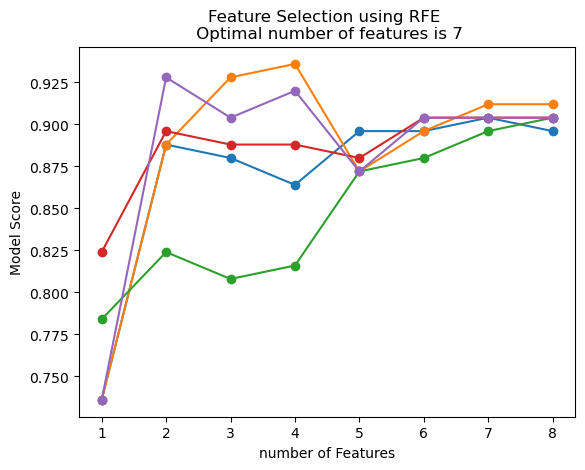

In [24]:
plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count}")

In [25]:
# model training
clf = LogisticRegression(random_state = 42, max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [26]:
y_pred_class = clf.predict(X_test)
y_pred_class

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0], dtype=int64)

In [28]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred_prob

array([9.98125160e-03, 1.66721151e-01, 7.79063985e-01, 5.13665047e-02,
       4.89391586e-03, 9.31728129e-01, 2.85778040e-05, 4.77249015e-02,
       9.29179472e-06, 1.63752366e-04, 4.04281055e-02, 1.36727273e-02,
       2.90094720e-03, 5.65827522e-02, 1.25235257e-02, 4.32056804e-01,
       1.05439313e-02, 3.77264817e-04, 7.15143281e-03, 6.15081551e-02,
       6.12770159e-01, 7.46843276e-01, 7.46714808e-01, 5.88963554e-01,
       8.60457076e-04, 2.36299678e-03, 6.04251585e-03, 3.07542036e-01,
       1.52525093e-01, 1.33553088e-01, 8.33480561e-01, 9.99451927e-01,
       2.37824188e-01, 1.64040785e-02, 9.49569020e-02, 4.79080139e-05,
       9.84220687e-01, 1.37088295e-01, 1.54319026e-04, 6.26064475e-01,
       6.60969430e-04, 9.04457088e-03, 1.80363682e-02, 3.77331345e-01,
       1.92085213e-02, 2.20938188e-02, 8.56154228e-01, 2.09435824e-02,
       3.56217190e-02, 1.16402346e-02, 1.28676735e-01, 2.08019558e-01,
       6.38980211e-01, 1.33942107e-01, 2.16967711e-01, 1.35342371e-02,
      

In [29]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
conf_matrix

array([[107,   8],
       [ 13,  29]], dtype=int64)

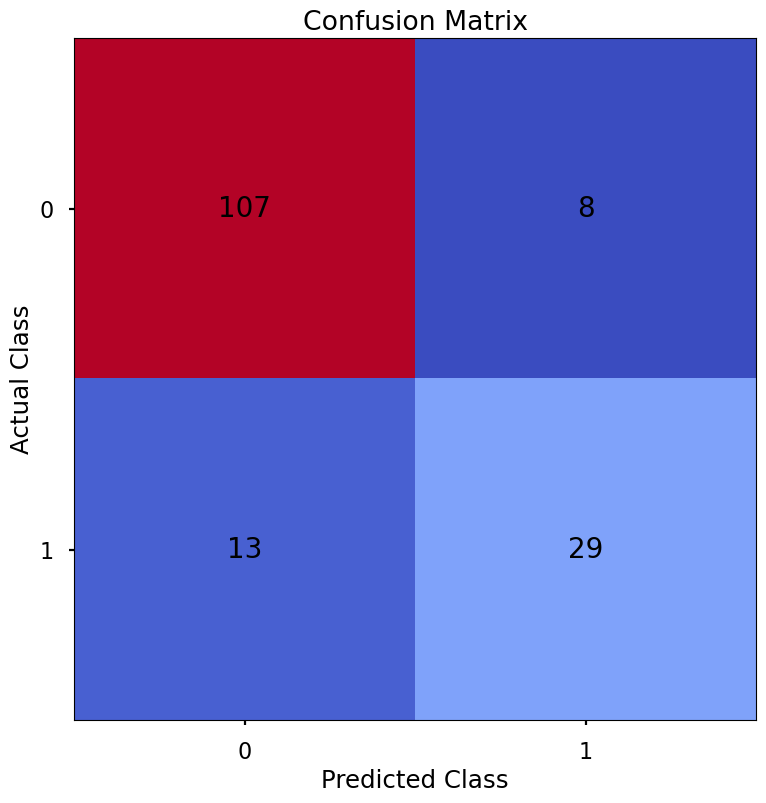

In [30]:
import numpy as np

plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value,ha ="center", va="center",fontsize=20)
plt.show()

In [31]:
# Accuracy (the number of correct classification out of all attempted classifications)
accuracy_score(y_test, y_pred_class)

0.8662420382165605

In [32]:
# Precision (of all observations that were predicted as positive, how many were actually positive)
precision_score(y_test, y_pred_class)

0.7837837837837838

In [33]:
# Recall (of all positive observations, how many did we predict as positive)
recall_score(y_test, y_pred_class)

0.6904761904761905

In [34]:
# F1-score (the harmonic mean of precision and recall)
f1_score(y_test, y_pred_class)

0.7341772151898734

#### Finding Optimal Threshold

In [36]:
thresholds = np.arange(0,1,0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [37]:
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    
    pred_class = (y_pred_prob >= threshold) * 1
    
    precision = precision_score(y_test, pred_class, zero_division = 0)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, pred_class)
    recall_scores.append(recall)
    
    f1 = f1_score(y_test, pred_class)
    f1_scores.append(f1)

In [42]:
max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)

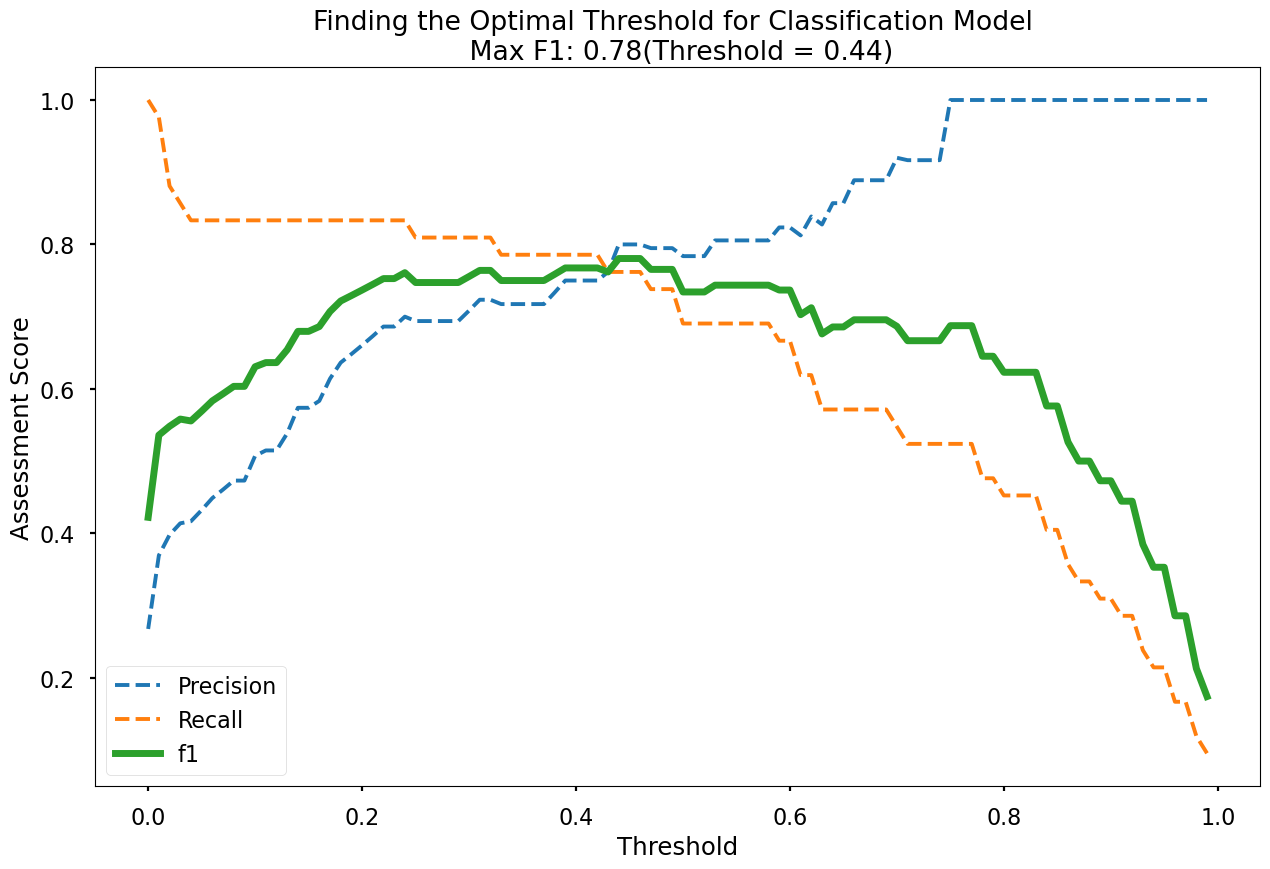

In [43]:
plt.style.use('seaborn-poster')
plt.plot(thresholds, precision_scores, label = "Precision", linestyle = "--")
plt.plot(thresholds, recall_scores, label = "Recall", linestyle = "--")
plt.plot(thresholds, f1_scores, label = "f1", linewidth = 5)
plt.title(f"Finding the Optimal Threshold for Classification Model \n Max F1: {round(max_f1,2)}(Threshold = {round(thresholds[max_f1_idx],2)})")
plt.xlabel("Threshold")
plt.ylabel("Assessment Score")
plt.legend(loc = "lower left")
plt.tight_layout()
plt.show()

In [44]:
optimal_threshold = 0.44
y_pred_class_opt_thresh = (y_pred_prob >= optimal_threshold) * 1
y_pred_class_opt_thresh

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0])